**IBRES Maxime - M2 SIGMA** | Série temporelle : **Bretagne 24-25** |  Date de rendue : **30 Janvier 2026**

---

# === Importation des librairies utiles au projet ===

In [74]:
# Chemins
import os
import sys
sys.path.append("..")

import geopandas as gpd
import pandas as pd
import numpy as np

# Graphiques
import matplotlib.pyplot as plt

# Images
from osgeo import gdal

# Classification supervisée
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import time

# Librairie personnelle
from libsigma import read_and_write as rw
from libsigma import plot_confusion_matrix as pcm
from libsigma import plots
import my_function as mf

# === Configuration ===

## --- Chemins ---

In [86]:
# == Dossier de travail ==
dir_path = "/home/onyxia/work"

# == Dossier des données ==
data_path = os.path.join(dir_path, "data/projet_eval")

# == Les données ==
# Les échantillons de photointerprétation
shp_path = os.path.join(data_path, "PI_strates_bretagne_32630.shp")

# Les série temporelle d’images Sentinel-2
path_B02 = os.path.join(data_path, "bretagne_24-25_B02.tif")
path_B03 = os.path.join(data_path, "bretagne_24-25_B03.tif")
path_B04 = os.path.join(data_path, "bretagne_24-25_B04.tif")
path_B05 = os.path.join(data_path, "bretagne_24-25_B05.tif")
path_B08 = os.path.join(data_path, "bretagne_24-25_B08.tif")
path_B8A = os.path.join(data_path, "bretagne_24-25_B8A.tif")
path_B11 = os.path.join(data_path, "bretagne_24-25_B11.tif")
path_B12 = os.path.join(data_path, "bretagne_24-25_B12.tif")

# == Les résultats ==
# Dossier des cartes
result_path = os.path.join(dir_path, "results")
os.makedirs(result_path, exist_ok=True)

# Chemin des cartes
path_output_nari = os.path.join(result_path, 'ARI_serie_temp.tif')

# Dossier des figures
figure_path = os.path.join(result_path, "figure")
os.makedirs(figure_path, exist_ok=True)

# Chemins des figures
diag_nb_poly_path = os.path.join(figure_path, "diag_baton_nb_poly_by_class.png")
diag_nb_pix_path = os.path.join(figure_path, "diag_baton_nb_pix_by_class.png")
path_output_nari_series = os.path.join(figure_path, "ARI_series.png")
path_matrix = os.path.join(figure_path, "matrice_confusion.png")
path_quality = os.path.join(figure_path, "qualite_by_class.png")

## --- Données de travail ---

### ➥ Nomenclatures des strates

In [77]:
CLASSES_INFO = {
    1: {'label': 'Sol Nu', 'color': 'lightgray'},
    2: {'label': 'Herbe', 'color': 'yellowgreen'},
    3: {'label': 'Landes', 'color': 'sandybrown'},
    4: {'label': 'Arbre', 'color': 'forestgreen'}
}

# Extraction automatique pour les graphes
LABELS_LIST = [v['label'] for k, v in CLASSES_INFO.items()]
LABELS_DICT = {k: v['label'] for k, v in CLASSES_INFO.items()}
COLORS_LIST = [v['color'] for k, v in CLASSES_INFO.items()]
NAME_TO_COLOR = {v['label']: v['color'] for k, v in CLASSES_INFO.items()}
clean_labels = ['Herbe', 'Landes', 'Arbre']

### ➥ Échantillons obtenues par photo interprétation

In [20]:
gdf = gpd.read_file(shp_path)
label_strates = 'strate'
print(f"Nombre total d'échantillons chargés : {len(gdf)}")
display(gdf.head())

Nombre total d'échantillons chargés : 278


,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


## --- Bug sur les graphiques ---

In [21]:
# Désactive LaTeX pour tout le reste du notebook (= PBM avec fonction de matrice de confusion)
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'sans-serif'
})
print("Configuration Matplotlib réparée : LaTeX désactivé.")

Configuration Matplotlib réparée : LaTeX désactivé.


# === Analyse des échantillons ===

In [22]:
# A. Nombre de polygones
# value_counts compte les occurrences, sort_index remet les classes 1, 2, 3, 4 dans l'ordre
serie_poly = gdf[label_strates].value_counts().sort_index()

# B. Nombre de pixels
# Sentinel-2 a une résolution de 10m (1 pixel = 100m²)
gdf['pixels_estimes'] = gdf.geometry.area / 100
serie_pix = gdf.groupby(label_strates)['pixels_estimes'].sum()

# C. Application des labels pour l'affichage
serie_poly.index = serie_poly.index.map(LABELS_DICT)
serie_pix.index = serie_pix.index.map(LABELS_DICT)

## --- Tableau récapitulatif bilan ---

In [23]:
df_recap = pd.DataFrame({
    'Nb Polygones': serie_poly,
    'Nb Pixels (est.)': serie_pix
})

total_poly = df_recap['Nb Polygones'].sum()
total_pix = df_recap['Nb Pixels (est.)'].sum()

df_recap['% Polygones'] = (df_recap['Nb Polygones'] / total_poly) * 100
df_recap['% Pixels'] = (df_recap['Nb Pixels (est.)'] / total_pix) * 100

row_total = pd.DataFrame({
    'Nb Polygones': [total_poly], 
    'Nb Pixels (est.)': [total_pix],
    '% Polygones': [100.0],
    '% Pixels': [100.0]
}, index=['TOTAL'])

df_recap_final = pd.concat([df_recap, row_total])

display(df_recap_final.style.format({
    'Nb Polygones': '{:.0f}',
    'Nb Pixels (est.)': '{:,.0f}',
    '% Polygones': '{:.2f} %',
    '% Pixels': '{:.2f} %'
}))

,Nb Polygones,Nb Pixels (est.),% Polygones,% Pixels
Herbe,86,"1,075",30.94 %,27.58 %
Landes,121,"1,602",43.53 %,41.08 %
Arbre,71,"1,222",25.54 %,31.34 %
TOTAL,278,"3,899",100.00 %,100.00 %


## --- Graphiques ---

In [24]:
colors_poly = [NAME_TO_COLOR[label] for label in serie_poly.index]
colors_pix = [NAME_TO_COLOR[label] for label in serie_pix.index]

In [25]:
# A. Graphique Polygones
plt.figure(figsize=(8, 6))
ax_p = serie_poly.plot(kind='bar', color=colors_poly)
ax_p.bar_label(ax_p.containers[0], padding=3)
plt.title("Répartition du nombre de polygones par classe")
plt.ylabel("Nombre de polygones")
plt.xlabel("")
plt.xticks(rotation=0)
plt.ylim(0, serie_poly.max() * 1.1)
plt.savefig(diag_nb_poly_path, bbox_inches='tight')
plt.close()
print(f"=> Graphique sauvegardé dans {diag_nb_poly_path}.")

# B. Graphique Pixels
plt.figure(figsize=(8, 6))
ax_px = serie_pix.plot(kind='bar', color=colors_pix)
ax_px.bar_label(ax_px.containers[0], fmt='{:,.0f}', padding=3)
plt.title("Répartition du nombre de pixels (estimé) par classe")
plt.ylabel("Nombre de pixels")
plt.xlabel("")
plt.xticks(rotation=0)
plt.ylim(0, serie_pix.max() * 1.1)
plt.savefig(diag_nb_pix_path, bbox_inches='tight')
plt.close()
print(f"=> Graphique sauvegardé dans {diag_nb_pix_path}.")

=> Graphique sauvegardé dans /home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png.
=> Graphique sauvegardé dans /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png.


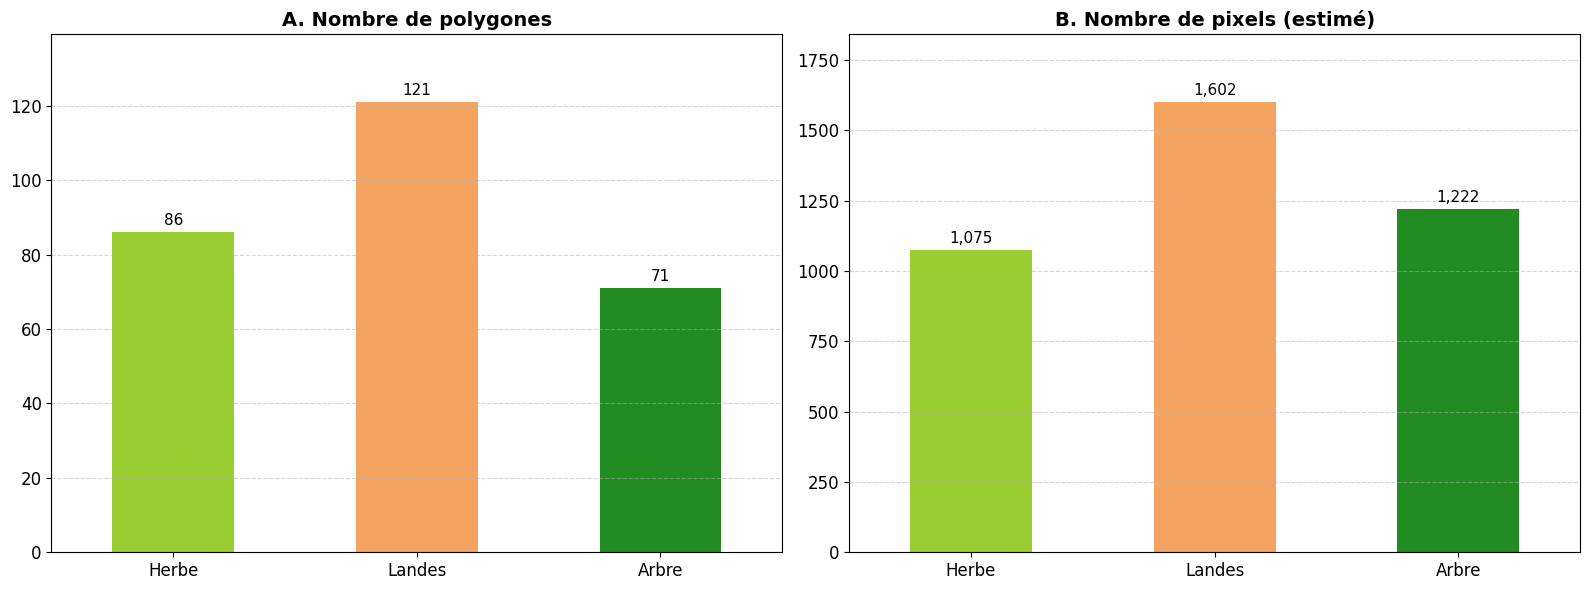

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphe de gauche (Polygones)
serie_poly.plot(kind='bar', ax=ax1, color=colors_poly, rot=0)
ax1.set_title("A. Nombre de polygones", fontsize=14)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_ylim(0, serie_poly.max() * 1.15)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.bar_label(ax1.containers[0], padding=3, fontsize=11)

# Graphe de droite (Pixels)
serie_pix.plot(kind='bar', ax=ax2, color=colors_pix, rot=0)
ax2.set_title("B. Nombre de pixels (estimé)", fontsize=14)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_ylim(0, serie_pix.max() * 1.15)
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.bar_label(ax2.containers[0], fmt='{:,.0f}', padding=3, fontsize=11)

plt.tight_layout()
plt.show()

On observe une prédominance de la classe "Landes", à la fois en nombre de polygones et en nombre de pixels. C'est intéressant car c'est la classe cible principale de l'étude (pour la mise en évidence des éricacées). Les classes "Herbe" et "Arbre" sont moins représentées mais restent dans un ordre de grandeur comparable. Aucun polygone de la classe "Sol Nu" n'est présent dans le fichier d'échantillons.

## === Phénologie des strates (mise en évidence des landes) ===

Nous allons calculer l'indice NARI (Normalized Anthocyanin Reflectance Index) pour mettre en évidence la présence de pigments rouges (anthocyanes) caractéristiques des landes (Ericaceae) en période de stress ou de floraison.

**Formule utilisée :**
$$ARI = \frac{\\1/B03 - \\1/B05}{\\1/B03 + \\1/B05}$$

## --- Calcul de l'indice NARI et Sauvegarde ---

In [27]:
# Chargement
arr_b03 = rw.load_img_as_array(path_B03).astype('float32')
arr_b05 = rw.load_img_as_array(path_B05).astype('float32')

# Gestion des zéros pour éviter la division par zéro
arr_b03[arr_b03 == 0] = np.nan
arr_b05[arr_b05 == 0] = np.nan

# Calcul vectorisé numpy
term_b03 = 1 / arr_b03
term_b05 = 1 / arr_b05
ari = (term_b03 - term_b05) / (term_b03 + term_b05)

# Nettoyage des NoData (NaN -> -9999)
ari = np.nan_to_num(ari, nan=-9999)

# Sauvegarde du résultat
ds_ref = rw.open_image(path_B03) # Pour récupérer la projection
rw.write_image(
    out_filename=path_output_nari,
    array=ari,
    data_set=ds_ref,
    gdal_dtype=gdal.GDT_Float32,
    driver_name="GTiff"
)

# Ajout manuel du tag NoData dans les métadonnées (Proposition GEMINI en tant que bonne pratique)
ds = gdal.Open(path_output_nari, gdal.GA_Update)
for i in range(ds.RasterCount):
    ds.GetRasterBand(i+1).SetNoDataValue(-9999)
ds = None

print(f"=> Fichier ARI généré : {path_output_nari}")

=> Fichier ARI généré : /home/onyxia/work/results/ARI_serie_temp.tif


## --- Analyse temporelle ---

Les valeurs mathématiques de l'indice ARI sont bien dans le fichier ARI_serie_temp.tif MAIS ce fichier est "aveugle". Il contient des millions de pixels avec des valeurs, mais il ne sait pas ce que ces pixels représentent. Pour lui, un pixel de lande ou un pixel d'herbe, c'est juste un chiffre à une coordonnée (x, y). Nous croisons donc la série temporelle d'ARI produite avec les échantillons de terrain (polygones = shape) pour extraire la signature moyenne de chaque strate.

### ➥ Extraction des statistiques par classe

In [28]:
# Dates de la série (Bretagne 24-25)
dates_str = [
    '2025-03-31', '2025-04-10', '2025-05-15', 
    '2025-06-17', '2025-07-12', '2025-08-10'
]
dates = pd.to_datetime(dates_str)

# Chargement de la série ARI générée
ari_cube = rw.load_img_as_array(path_output_nari).astype('float32')
ari_cube[ari_cube == -9999] = np.nan # On remet en NaN pour les stats

# Rastérisation des échantillons
mask_classes = mf.rasterize_samples(path_output_nari, shp_path, field_name='strate')

# Calcul des moyennes et écart-types
stats = {}

for class_id, info in CLASSES_INFO.items():
    
    # Récupération du nom depuis la config
    class_name = info['label']
    
    # Masque booléen
    is_class = (mask_classes == class_id)
    
    if np.sum(is_class) > 0:
        values = ari_cube[is_class] # (N_pixels, N_dates)
        
        stats[class_name] = {
            'mean': np.nanmean(values, axis=0),
            'std': np.nanstd(values, axis=0),
            'color': info['color'] 
        }


### ➥ Génération du graphique

In [29]:
colors = {v['label']: v['color'] for k, v in CLASSES_INFO.items()}

=> Graphique sauvegardé : /home/onyxia/work/results/figure/ARI_series.png


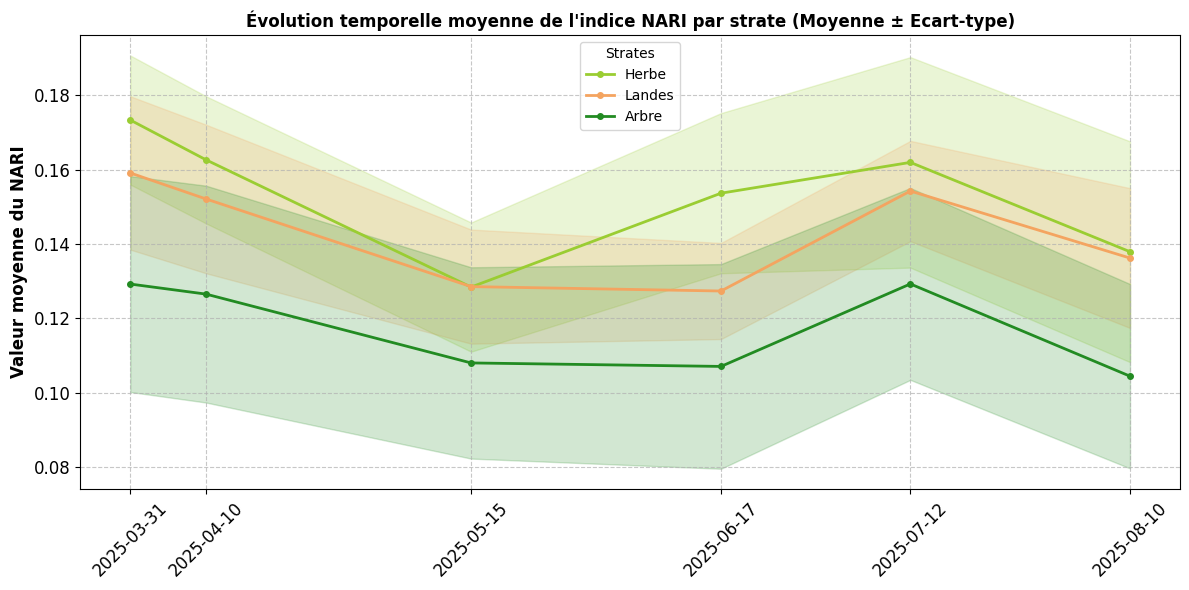

In [30]:
plt.figure(figsize=(12, 6))

for class_name, data in stats.items():
    c = colors.get(class_name, 'gray')
    
    # Tracé Moyenne
    plt.plot(dates, data['mean'], label=class_name, color=c, linewidth=2, marker='o', markersize=4)
    
    # Tracé Écart-type (zone ombrée)
    plt.fill_between(dates, 
                     data['mean'] - data['std'], 
                     data['mean'] + data['std'], 
                     color=c, alpha=0.2)

# Mise en forme
plt.title("Évolution temporelle moyenne de l'indice NARI par strate (Moyenne ± Ecart-type)")
plt.ylabel("Valeur moyenne du NARI")
plt.legend(title="Strates")
plt.grid(True, linestyle='--', alpha=0.7)

# Gestion des dates en abscisse
plt.xticks(dates, dates.strftime('%Y-%m-%d'), rotation=45)

# Sauvegarde et Affichage
plt.tight_layout()
plt.savefig(path_output_nari_series, dpi=150)
print(f"=> Graphique sauvegardé : {path_output_nari_series}")

plt.show()

# === Production d’une carte de strates à l’échelle du pixel ===

## --- Préparation de la Matrice X (Features) et du Vecteur Y (Labels) ---

In [32]:
# --- 1. Liste de TOUTES les images à utiliser (Features) ---
# L'ordre n'importe pas pour le modèle, mais garde-le en tête pour l'analyse plus tard.
input_files = [
    # Les bandes brutes (Séries Temporelles)
    path_B02, path_B03, path_B04, path_B05, 
    path_B08, path_B8A, path_B11,path_B12,
    # Indice ARI calculé (Feature Engineering)
    path_output_nari
]

# --- 2. Chargement et Empilement (Stacking) ---
print("Chargement et empilement des bandes...")

features_list = []
ref_shape = None # Pour vérifier que toutes les images ont la même taille

for f in input_files:
    if not os.path.exists(f):
        print(f" Fichier introuvable, ignoré -> {f}")
        continue
    # Chargement de l'image (Lignes, Colonnes, Dates)
    img = rw.load_img_as_array(f).astype('float32')
    # Vérification des dimensions
    if ref_shape is None:
        ref_shape = img.shape[:2] # (Lignes, Colonnes)
    elif img.shape[:2] != ref_shape:
        print(f"Erreur de dimension pour {f} : {img.shape[:2]} vs {ref_shape}")
        continue 
    # On ajoute ce cube à la liste
    features_list.append(img)
    print(f" -> Ajouté : {os.path.basename(f)} ({img.shape[2]} dates)")

# Concaténation finale : on colle tout sur l'axe des "variables" (axe 2)
X_full = np.concatenate(features_list, axis=2)

# --- 3. Création de la Vérité Terrain (Y) ---
# La première image de la liste comme référence pour la géométrie
mask_classes = mf.rasterize_samples(input_files[0], shp_path, field_name='strate')

# --- 4. Extraction des Pixels d'Entraînement ---

# On cherche les positions où on a une classe (valeur > 0)
valid_pixels = (mask_classes > 0)
# Extraction de X (Tableau des variables)
X = X_full[valid_pixels, :]
# Extraction de Y (Tableau des classes)
Y = mask_classes[valid_pixels]
# Nettoyage final (Remplacement des NaNs par 0 pour le Random Forest)
X = np.nan_to_num(X, nan=0.0)

# --- 5. Bilan ---
print("\n=== BILAN ===")
print(f"Dimensions de l'image empilée : {X_full.shape}")
print(f" -> Lignes : {X_full.shape[0]}")
print(f" -> Colonnes : {X_full.shape[1]}")
print(f" -> Total Variables (Dates x Bandes) : {X_full.shape[2]}")
print("-" * 30)
print(f"Dimensions finales pour le modèle :")
print(f" -> X (Pixels d'entraînement) : {X.shape}") 
print(f" -> Y (Classes cibles)        : {Y.shape}")

Chargement et empilement des bandes...
 -> Ajouté : bretagne_24-25_B02.tif (6 dates)
 -> Ajouté : bretagne_24-25_B03.tif (6 dates)
 -> Ajouté : bretagne_24-25_B04.tif (6 dates)
 -> Ajouté : bretagne_24-25_B05.tif (6 dates)
 -> Ajouté : bretagne_24-25_B08.tif (6 dates)
 -> Ajouté : bretagne_24-25_B8A.tif (6 dates)
 -> Ajouté : bretagne_24-25_B11.tif (6 dates)
 -> Ajouté : bretagne_24-25_B12.tif (6 dates)
 -> Ajouté : ARI_serie_temp.tif (6 dates)

=== BILAN ===
Dimensions de l'image empilée : (612, 1533, 54)
 -> Lignes : 612
 -> Colonnes : 1533
 -> Total Variables (Dates x Bandes) : 54
------------------------------
Dimensions finales pour le modèle :
 -> X (Pixels d'entraînement) : (3839, 54)
 -> Y (Classes cibles)        : (3839,)


## --- Choix du classifieur et sa paramètrisation ---

### ➥ Train/Test split --> (70%)/(30%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=0 
)

print(f" -> Données d'entraînement : {X_train.shape[0]} pixels")
print(f" -> Données de test : {X_test.shape[0]} pixels")

 -> Données d'entraînement : 2687 pixels
 -> Données de test : 1152 pixels


### ➥ Définition du modèle et de la grille

In [ ]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 5]
}

### ➥ Cross-validation stratifiée

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### ➥ Grille de recherche = GridSearchCV

In [ ]:
print("Lancement de l'optimisation (GridSearchCV)...")

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

# Entraînement avec recherche des meilleurs hyperparamètres (Sur le TRAIN seulement)
grid.fit(X_train, y_train)

print(f"Optimisation terminée.")

Lancement de l'optimisation (GridSearchCV)...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   9.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=   9.8s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  10.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  10.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  10.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  16.8s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  17.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  17.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total 

NameError: name 'accuracy_score' is not defined

### ➥ Résultats de l'optimisation

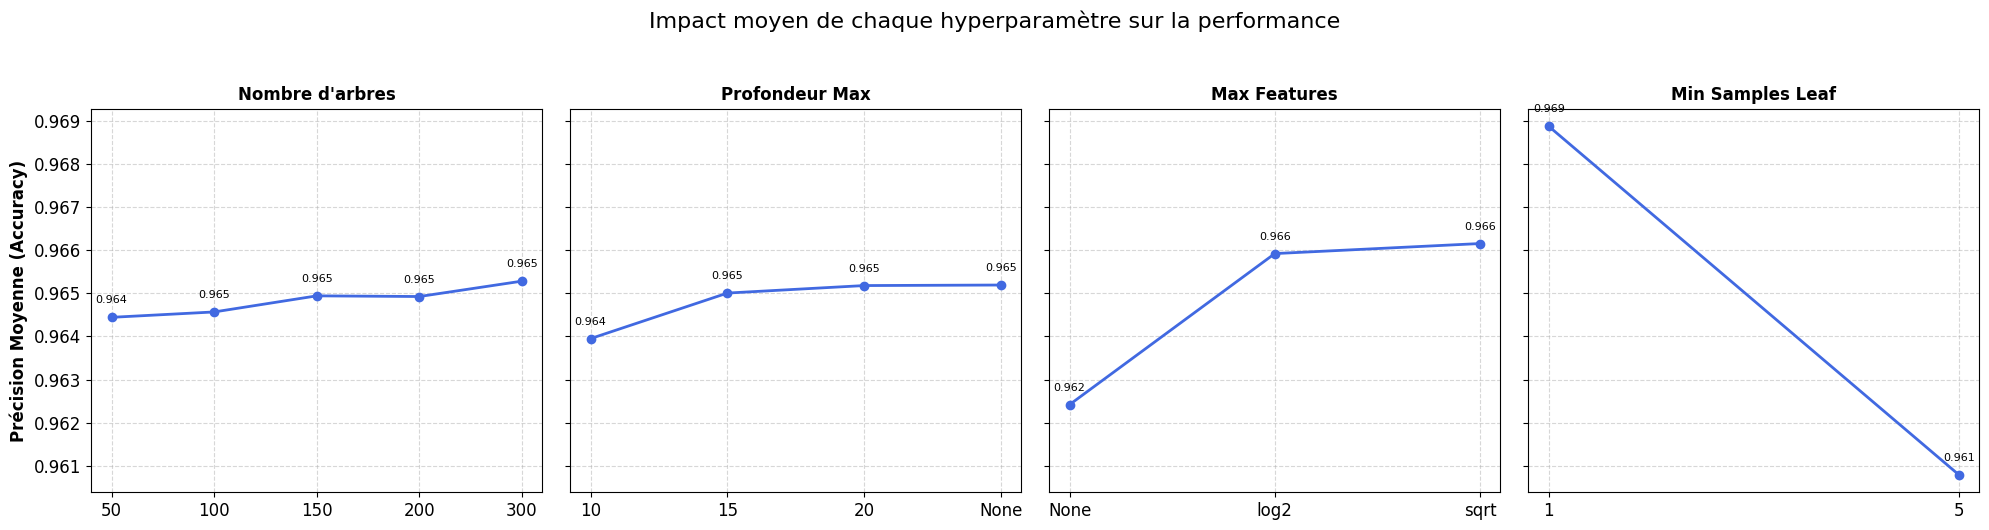

In [117]:
# Préparation des données
df_results = pd.DataFrame(grid.cv_results_)

# Liste des paramètres à analyser
params_list = ['param_n_estimators', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf']
titles = ["Nombre d'arbres", "Profondeur Max", "Max Features", "Min Samples Leaf"]

# Création de la figure (1 ligne, 4 colonnes)
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i, param in enumerate(params_list):
    ax = axes[i]
    temp_col = df_results[param].fillna('None')
    
    # Regroupement par valeur du paramètre et prend la moyenne du score
    grouped = df_results.groupby(temp_col)['mean_test_score'].mean()
    
    # Si les index sont numériques, trie
    try:
        grouped = grouped.sort_index()
    except:
        pass

    # Tracé de la courbe
    # x = les valeurs du paramètre (index), y = le score moyen
    x_vals = [str(x) for x in grouped.index] # On convertit en string pour l'axe X
    y_vals = grouped.values
    
    ax.plot(x_vals, y_vals, marker='o', linewidth=2, linestyle='-', color='royalblue')
    
    # Mise en forme
    ax.set_title(titles[i], fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Ajout de la valeur du score au dessus des points pour être précis
    for x, y in zip(x_vals, y_vals):
        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

axes[0].set_ylabel("Précision Moyenne (Accuracy)")
plt.suptitle("Impact moyen de chaque hyperparamètre sur la performance", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [109]:
df_params = pd.DataFrame(list(grid.best_params_.items()), columns=['Hyperparamètre', 'Optimisé'])
print(f"Score CV moyen de la combinaison optimisée : {grid.best_score_:.4f}")
display(df_params.style.hide(axis='index'))

Score CV moyen de la combinaison optimisée : 0.9728


Hyperparamètre,Optimisé
max_depth,None
max_features,sqrt
min_samples_leaf,1
n_estimators,300


La combinaison optimale retenue par le GridSearch (grid.best_params_) correspond exactement à la réunion des optimums locaux de chaque hyperparamètres comme vu sur les graphiques de la précision moyenne de chaque cas.

In [111]:
# Modèle final (Le meilleur trouvé)
best_model = grid.best_estimator_
best_rf = best_model

### ➥ Evaluation sur le test (La vérité terrain)

In [ ]:
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f"Accuracy test : {acc_test:.4f}")

Accuracy test : 0.9661


## --- Stratégie de validation : importance des variables ---

In [ ]:
# Génération des noms complets pour les 54 variables
expanded_feature_names = []

for f in input_files:
    filename = os.path.basename(f)
    # Récupération du nombre de bande
    ds = rw.open_image(f)
    nb_bands = ds.RasterCount
    ds = None # Fermeture propre
    
    for i in range(nb_bands):
        if 'dates_str' in locals() and len(dates_str) == nb_bands:
             expanded_feature_names.append(f"{filename}_{dates_str[i]}")
        else:
             expanded_feature_names.append(f"{filename}_Date{i+1}")

print(f"Nombre de variables nommées : {len(expanded_feature_names)}")
print(f"Nombre d'importances du modèle : {len(best_rf.feature_importances_)}")

# Création du dataframe
df_importance = pd.DataFrame({
    'Variable': expanded_feature_names,
    'Importance': best_rf.feature_importances_
})
# Tri par importance décroissante
df_importance = df_importance.sort_values(by='Importance', ascending=False)

Nombre de variables nommées : 54
Nombre d'importances du modèle : 54


### ➥ Les 15 variables qui expliquent le mieux le modèle

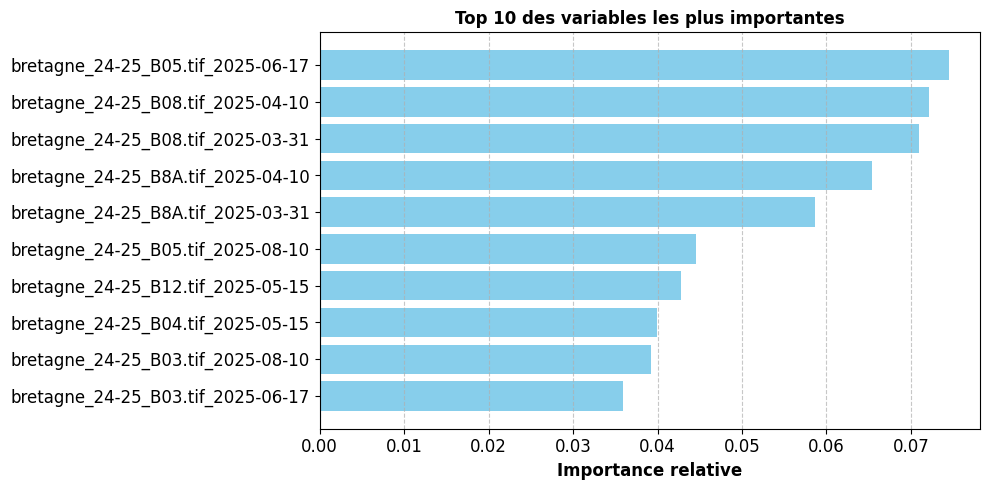

In [ ]:
plt.figure(figsize=(10, 5))
# Inverse l'ordre pour l'affichage (le meilleur en haut)
plt.barh(df_importance['Variable'].head(10)[::-1], 
         df_importance['Importance'].head(10)[::-1], 
         color='skyblue')
plt.xlabel("Importance relative")
plt.title("Top 10 des variables les plus importantes")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [59]:
# Affichage textuel
print(f"Somme des importances : {df_importance['Importance'].sum():.4f}") # Vérification
print("Top 10 des variables décisives :")
print(df_importance.head(10))

Somme des importances : 1.0000
Top 5 des variables décisives :
                             Variable  Importance
21  bretagne_24-25_B05.tif_2025-06-17    0.074463
25  bretagne_24-25_B08.tif_2025-04-10    0.072109
24  bretagne_24-25_B08.tif_2025-03-31    0.071000
31  bretagne_24-25_B8A.tif_2025-04-10    0.065345
30  bretagne_24-25_B8A.tif_2025-03-31    0.058602
23  bretagne_24-25_B05.tif_2025-08-10    0.044549
44  bretagne_24-25_B12.tif_2025-05-15    0.042833
14  bretagne_24-25_B04.tif_2025-05-15    0.039880
11  bretagne_24-25_B03.tif_2025-08-10    0.039260
9   bretagne_24-25_B03.tif_2025-06-17    0.035969


## --- Production des cartes finales ---

In [94]:
print("Chargement des données complètes pour la carte finale...")
# 1. On recharge TOUTES les images (comme à l'étape 1) pour avoir la couverture totale
# (L'étape 1 avait déjà créé X_full, mais on le refait ici pour être sûr d'avoir l'image entière si on avait filtré avant)
features_list = []
ref_ds = None 

# On réutilise la liste 'input_files' qui contient les 54 fichiers triés
for f in input_files:
    img = rw.load_img_as_array(f).astype('float32')
    features_list.append(img)
    
    # On garde une référence pour la sauvegarde finale (projection, géotransform)
    if ref_ds is None:
        ref_ds = rw.open_image(f)

# Empilement
X_map = np.concatenate(features_list, axis=2)
rows, cols, bands = X_map.shape
print(f"Image composite créée : {rows}x{cols} pixels, {bands} bandes.")

# 2. Préparation pour le modèle (Aplatissement)
# On passe de (Lignes, Colonnes, Bandes) à (Lignes*Colonnes, Bandes)
X_map_flat = X_map.reshape(rows * cols, bands)

# Gestion des NaNs (ex: bordures noires) -> 0
X_map_flat = np.nan_to_num(X_map_flat, nan=0.0)

# 3. Prédiction
print("Prédiction en cours sur toute l'image ...")
# On utilise le modèle optimisé 'best_rf'
Y_map_flat = best_rf.predict(X_map_flat)

# 4. Reconstruction de l'image
carte_strates = Y_map_flat.reshape(rows, cols)

# 5. Sauvegarde
output_map_path = os.path.join(result_path, "carte_strates.tif")

# On écrit le fichier
rw.write_image(
    out_filename=output_map_path,
    array=carte_strates,
    data_set=ref_ds,
    gdal_dtype=gdal.GDT_Byte,
    driver_name="GTiff"
)

# Ajout du NoData=0 (Le fond de carte est souvent 0, mais vos classes sont 1,2,3,4)
ds = gdal.Open(output_map_path, gdal.GA_Update)
ds.GetRasterBand(1).SetNoDataValue(0)
ds = None

print(f"=> Carte générée : {output_map_path}")

Chargement des données complètes pour la carte finale...
Image composite créée : 612x1533 pixels, 54 bandes.
Prédiction en cours sur toute l'image ...
=> Carte générée : /home/onyxia/work/results/carte_strates.tif


## --- Analyse des résultats ---

Figures images sauvegardées dans :
   - /home/onyxia/work/results/figure/matrice_confusion.png
   - /home/onyxia/work/results/figure/qualite_by_class.png


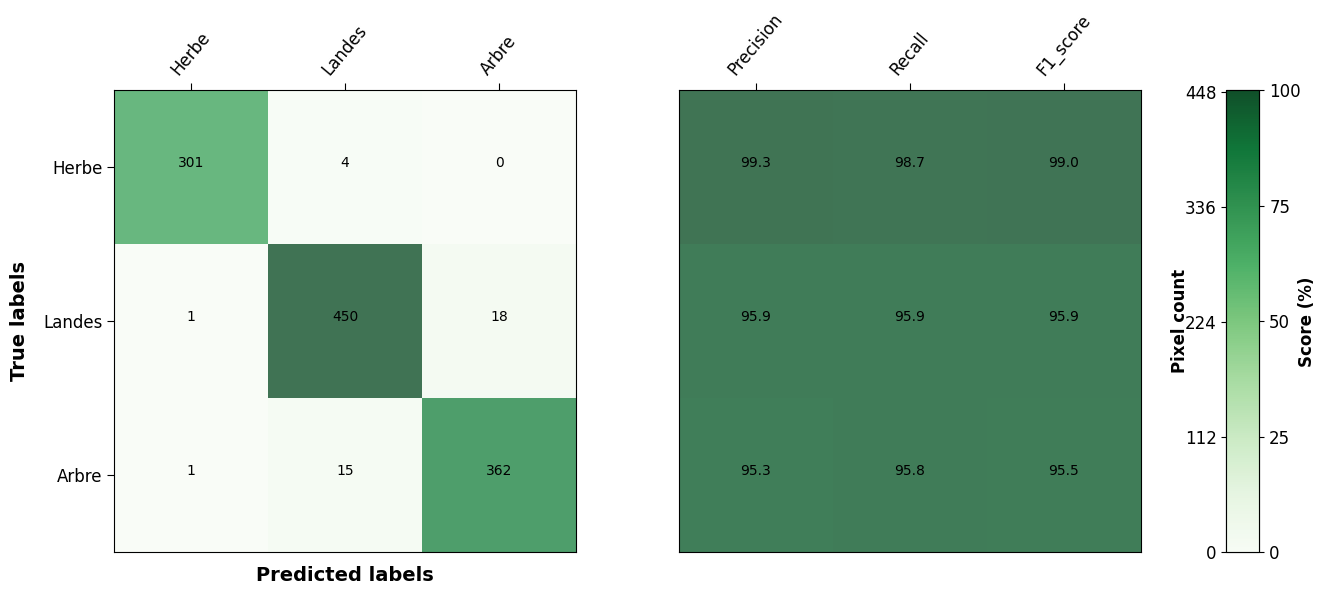

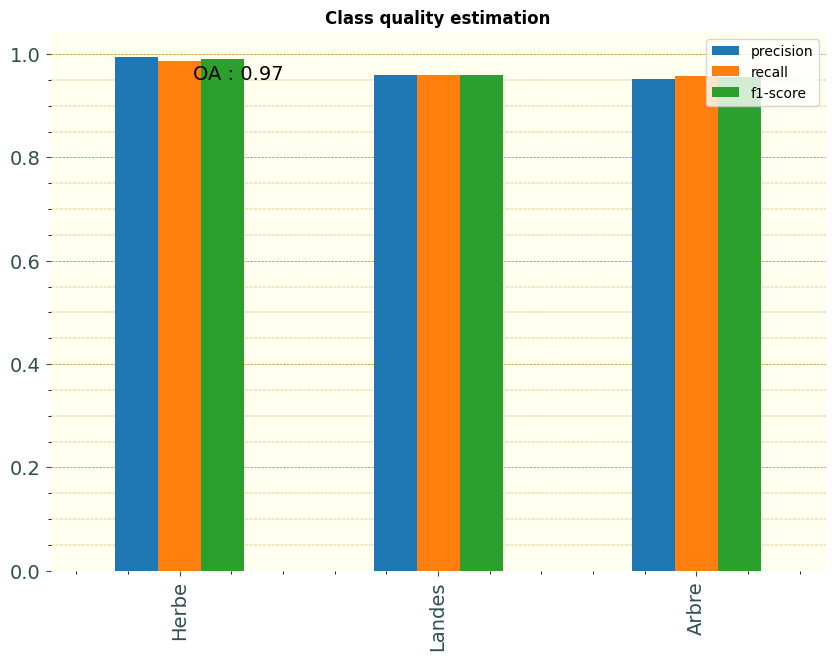

In [ ]:
# Calcul des métriques nécessaires
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Le rapport doit être sous forme de DICTIONNAIRE pour que la fonction puisse le lire
report = classification_report(y_test, y_pred, target_names=clean_labels, output_dict=True)

# Graphique 1 : Matrice de Confusion
plots.plot_cm(
    cm=cm, 
    labels=clean_labels,
    out_filename=path_matrix,
    normalize=False
)

# 4. Graphique 2 : Qualité par Classe (Bâtons)
plots.plot_class_quality(
    report=report, 
    accuracy=accuracy, 
    out_filename=path_quality
)

# Affichage
print(f"Figures images sauvegardées dans :")
print(f"   - {path_matrix}")
print(f"   - {path_quality}")
plt.show()

# === Discussions ===